### - Fig. 5 or 5/6:  
### - option 1: time series between isopycnal depth and Tbox1 
###           composite bit that shows isopycnal depth
###           transect cross-slope, do the same composite. (I think that can stay out because I have already done it on Figure 2)



In [1]:
pwd

'/home/581/ns3783'

## First run the function to detrend the time series later on 

### Function for doing spatial correlations/regressions:

#### This comes from http://hrishichandanpurkar.blogspot.com/2017/09/vectorized-functions-for-correlation.html


In [1]:
def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr

# detrending function:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

## Creating variables for the composite first

In [2]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean.cm as cmocean
from collections import OrderedDict
import cartopy.crs as ccrs
import matplotlib.path as mpath
import cftime
import glob
import dask
import os
import datetime
import matplotlib.colors as col
import gsw
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
# from cosima_cookbook import distributed as ccd

In [3]:
from dask.distributed import Client

print('starting distributed client...')
client = Client()
display(client)

starting distributed client...


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33159/status,
Dashboard: /proxy/33159/status,Workers: 7
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36877,Workers: 7
Dashboard: /proxy/33159/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:39741,Total threads: 4
Dashboard: /proxy/33161/status,Memory: 17.88 GiB
Nanny: tcp://127.0.0.1:37403,


In [4]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'

first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

### PREPARE TEMPERATURE

In [5]:
# load temperature data at 400m:
# depth average this is different because I am taking only temperature at 400m
depth_slice = 400
##loading the whole area in case we want to plot Totten as well
lat_slice  = slice(-75.5,-60)
lon_slice  = slice(-275, -230)

temp_400m = cc.querying.getvar(iaf_cycle3,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_400m = temp_400m.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice,method='nearest')

In [6]:
temp_400m = temp_400m.load()

### loading indexes previously calculated by "Selecting_peak_low_years" code stored in /Figures/New_codes_CFD

In [7]:
outpath = '/g/data/v45/ns3783/top_index.nc'
profile_data = xr.open_dataset(outpath)
top_id = profile_data.top_id

In [8]:
outpath = '/g/data/v45/ns3783/bottom_index.nc'
profile_data = xr.open_dataset(outpath)
bt_id = profile_data.bt_id

### creating the averages for peaks and lows

In [9]:
#full mean
temp_400m_avg = temp_400m.mean('time')
temp_400m_avg = temp_400m_avg.load()

#mean of all high peaks together
temp_high_avg=temp_400m[top_id].mean('time')
temp_high_avg = temp_high_avg.load()

#mean of all low peaks together
temp_low_avg=temp_400m[bt_id].mean('time')
temp_low_avg = temp_low_avg.load()

### ISOPYCNAL DEPTH 

In [10]:
# load temperature data at 200m (defined on transect):
lat_slice  = slice(-67,-63)
lon_slice  = slice(-256, -240)

temp_iso = cc.querying.getvar(iaf_cycle3,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_iso = temp_iso.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

sal_iso = cc.querying.getvar(iaf_cycle3,'salt' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
sal_iso = sal_iso.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

In [11]:
# calculate density along transect:
# arrays for gsw to use
depth_array = temp_iso*0 + temp_iso.st_ocean
lat_array = temp_iso*0 + temp_iso.yt_ocean
# need to convert practical salinity to absolute salinity:
pressure = gsw.p_from_z(-depth_array,lat_array)
# need to convert practical salinity to absolute salinity:
salt_abs = gsw.SA_from_SP(sal_iso,pressure,sal_iso.xt_ocean,lat_array)
#calculate sigma
sigma0 = gsw.sigma0(salt_abs,temp_iso)

In [12]:
sigma0=sigma0.load()

## We need to mask the shelf out 

In [13]:
# cut the data BOX 1
lon_slice  = slice(-255, -240)
lat_slice  = slice(-65.5, -63)

# topography data:
ht = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

fontsize=16

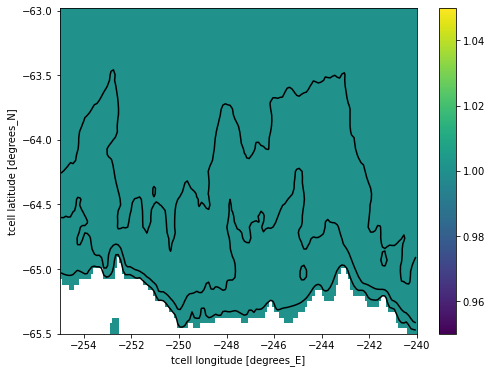

In [14]:
# Mask 

# set to 1 everywhere:
region_mask = ht*0 +1

# mask open ocean:
# shelf masking:
contour_file = np.load('/g/data/jk72/ns3783/Antarctic_slope_contour_700m.npz')
shelf_mask = contour_file['temp_mask']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1

shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

region_mask = region_mask * shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)


plt.figure(figsize=(8,6))
region_mask.plot()
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[1000,2000,3000],colors='k')
#plt.xlim(-275,-245)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')

In [15]:
#apply the mask
sigma0_off = sigma0*region_mask
sigma0_off = sigma0_off.where(sigma0_off!=0)

In [16]:
sigma0_off

<xarray.DataArray (time: 732, st_ocean: 75, yt_ocean: 58, xt_ocean: 150)>
dask.array<where, shape=(732, 75, 58, 150), dtype=float64, chunksize=(732, 75, 58, 150), chunktype=numpy.ndarray>
Coordinates:
  * yt_ocean  (yt_ocean) float64 -65.48 -65.44 -65.4 ... -63.09 -63.05 -63.0
  * xt_ocean  (xt_ocean) float64 -254.9 -254.8 -254.7 ... -240.2 -240.1 -240.0
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) datetime64[ns] 1958-01-16T12:00:00 ... 2018-12-16T12:00:00

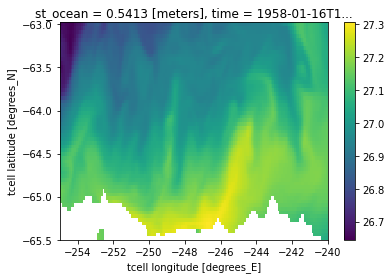

In [17]:
## first time step only:
sigma0_off[0,0,...].plot()

In [18]:
#load
sigma0_off=sigma0_off.load()

2024-12-04 17:14:34,431 - distributed.worker_memory - WARNING - Worker tcp://127.0.0.1:35107 (pid=2737719) exceeded 95% memory budget. Restarting...
2024-12-04 17:14:36,049 - distributed.scheduler - ERROR - Couldn't gather keys {"('where-63ce8e83edca2ae6ce324830be89a547', 0, 0, 0, 0)": ['tcp://127.0.0.1:35107']} state: ['memory'] workers: ['tcp://127.0.0.1:35107']
NoneType: None
2024-12-04 17:14:36,082 - distributed.scheduler - ERROR - Shut down workers that don't have promised key: ['tcp://127.0.0.1:35107'], ('where-63ce8e83edca2ae6ce324830be89a547', 0, 0, 0, 0)
NoneType: None
2024-12-04 17:14:36,088 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('where-63ce8e83edca2ae6ce324830be89a547', 0, 0, 0, 0)": ('tcp://127.0.0.1:35107',)}
2024-12-04 17:14:36,091 - distributed.nanny - WARNING - Restarting worker
2024-12-04 17:14:39,837 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/130106381.gadi-pbs/dask-worker-space/worker-ul4f1ggw', purg

In [19]:
rho_thresh = 27.82

# mask density where < rho_thresh:
sigma0_off_mask = sigma0_off.where(sigma0_off>rho_thresh)
# check this worked:
#sigma0_off_mask[0,:,:,0].plot()

# Now find first depth where sigma0_off_mask is not masked:
depth_array = sigma0_off*0 + sigma0_off.st_ocean
# mask depth array using density threshold:
depth_array_masked = depth_array.where(sigma0_off>rho_thresh)
# find minimum depth at each lat,lon location:
min_depth = depth_array_masked.min(dim='st_ocean')

#rename the isopycnal
iso2782_dth=min_depth

### shift the isopycnals here, because later is difficult to do it for the composites because of the amount of nans introduced by the masking 

In [20]:
## when we are shifting it, it doesn't liek the nans. I checked the minimum wasn't zero and replaced nans by zero to make it work 
#np.min(iso2782_dth) #and it is 0.54ish
iso2782_dth_sh=iso2782_dth.fillna(0)

In [21]:
#iso2782_dth_sh=iso2782_dth_sh.shift(time=-2).dropna(dim='time')

In [22]:
## now I have to put the nans back in place
teste=iso2782_dth_sh
teste_mask = teste.where(teste>0.5)
teste_array = teste*0 + teste
teste_array_masked = teste_array.where(teste>0.5)

In [23]:
#rename with the name it had previously. This one was before I deleted the load line so it all remains a xdarray
isocon=teste_array_masked;

### use indexes loaded previously for determining temp

### creating the averages for peaks and lows

In [24]:
#full mean
iso_avg = isocon.mean('time')
iso_avg = iso_avg.load()

#mean of all high peaks together
iso_high_avg=isocon[top_id].mean('time')
iso_high_avg = iso_high_avg.load()

#mean of all low peaks together
iso_low_avg=isocon[bt_id].mean('time')
iso_low_avg = iso_low_avg.load()

In [25]:
top_id

<xarray.DataArray 'top_id' (time: 131)>
array([ 61,  62,  63,  64,  65,  98, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 122, 123, 125, 126, 149, 197,
       198, 199, 215, 217, 218, 293, 294, 295, 296, 378, 379, 412, 413, 414,
       415, 416, 417, 418, 419, 420, 421, 422, 462, 534, 535, 536, 541, 542,
       543, 544, 545, 546, 547, 548, 549, 550, 552, 553, 554, 556, 557, 558,
       559, 560, 563, 564, 565, 568, 569, 570, 571, 572, 573, 574, 575, 576,
       577, 578, 579, 580, 581, 582, 583, 584, 585, 588, 589, 590, 617, 618,
       619, 620, 621, 622, 623, 624, 625, 626, 629, 630, 631, 632, 633, 634,
       635, 636, 637, 638, 639, 640, 641, 642, 643, 648, 649, 690, 692, 693,
       694, 695, 696, 697, 698])
Coordinates:
  * time     (time) datetime64[ns] 1963-02-15 ... 2016-03-16T12:00:00

### Creating variables for time series

#### TEMPERATURE BOX 1

In [26]:
# load temperature data at 400m:

depth_slice = slice(400, 6000)
# cut the data BOX 1
lon_slice  = slice(-252.7, -251.7)
lat_slice  = slice(-65.35, -65.1)

temp_400m = cc.querying.getvar(iaf_cycle3,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_400m = temp_400m.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice)

In [27]:
# depth average:
# there is no dzu saved
# calculate grid thickness, adjusted for partial cells:
zlevel1 = 400
zlevel2 = 6000

# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(iaf_cycle3,'st_edges_ocean',master_session,
                 start_time=start_time, end_time=end_time,n=1)
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean':temp_400m.yt_ocean,'xt_ocean':temp_400m.xt_ocean},axis=[1,2])
# import bathymetry:
ht = cc.querying.getvar(iaf_cycle3,'ht',master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<ht,other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(iaf_cycle3,'st_ocean',master_session,n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

# select correct depths:
thickness = thickness.sel(st_ocean=slice(zlevel1,zlevel2))

# multiply by thickness to avg
temp_400m = (temp_400m*thickness).sum('st_ocean')/thickness.sum('st_ocean')

In [28]:
#AREA WEIGHTING #area t cant be found at iaf_cycle3
# area weighting:
area_t = cc.querying.getvar('01deg_jra55v13_ryf9091','area_t',master_session, ncfile = 'ocean_grid.nc',n=-1)
area_t = area_t.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

# sum area:
area_t_sum = area_t.sum('xt_ocean').sum('yt_ocean')

# Apply area weight:
temp_400m = (temp_400m*area_t).sum('xt_ocean').sum('yt_ocean')/area_t_sum


In [29]:
#load the variable
temp_400m_za = temp_400m.load()

##test
#np.amin(temp_400m_za)

#### Detrend time series and apply rolling mean 

In [30]:
# Note we need to first detrend the data:
temp_400m_zad = detrend_dim(temp_400m_za,'time')
temp_400m_zadr = temp_400m_zad.rolling(time=12, center=True).mean()
temp_400m_zar = temp_400m_za.rolling(time=12, center=True).mean()

#### ISOPYCNALS 
##### Cut data loaded on previously, so we don't have t load it again

In [31]:
# cut the data BOX 1
lon_slice  = slice(-253, -251.5) # this is the best isopycnal
#lon_slice  = slice(-252.9, -252.1)
lat_slice  = slice(-67.5, -63)

# topography data:
ht = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

fontsize=16

##### MAKE MASK FOR BOX 1 offshore in between 1000 and 2000 isopycnals

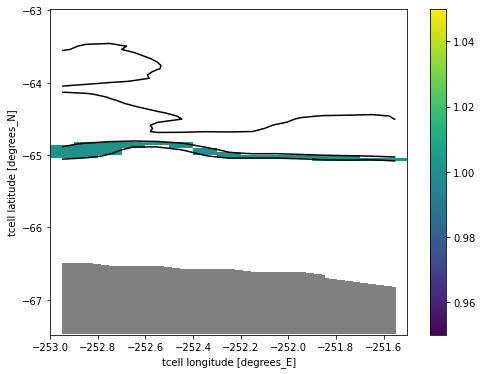

In [32]:
# Mask 

# set to 1 everywhere:
region_mask = ht*0 +1

# mask open ocean:
# shelf masking:
contour_file = np.load('/g/data/jk72/ns3783/Antarctic_slope_contour_10002000m.npz')
shelf_mask = contour_file['temp_mask']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

region_mask = region_mask * shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)


plt.figure(figsize=(8,6))
region_mask.plot()
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[1000,2000,3000],colors='k')
#plt.xlim(-275,-245)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')

In [33]:
#apply the mask iso 82
isocon2_off = iso2782_dth*region_mask
isocon2_off = isocon2_off.where(isocon2_off!=0)

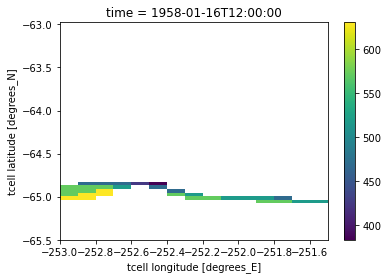

In [34]:
# first time step only:
isocon2_off[0,...].plot()

#### Load this new variables to guarantee plots will run smoothly 

In [35]:
isocon2_off = isocon2_off.load()


In [36]:
isocon2_off_a  = isocon2_off.mean('xt_ocean').mean('yt_ocean')


### shifting time series

In [37]:
isocon2_off_sh=isocon2_off_a 
#isocon2_off_sh=isocon2_off_sh.shift(time=-2).dropna(dim='time')

In [38]:
#isocon2_off_sh

#### Detrend and apply rolling mean 

In [39]:
# Note we need to first detrend the data:
isocon2_off_d = detrend_dim(isocon2_off_sh,'time')
isocon2_off_dr = isocon2_off_d.rolling(time=12, center=True).mean()
isocon2_off_r = isocon2_off_sh.rolling(time=12, center=True).mean()

### LOAD SPECIAL CONTOURS

In [40]:
# cut the data BOX 1
lon_slice  = slice(-253, -251.5) #isopycnal contour
lat_slice  = slice(-67, -63)

# topography data:
ht2 = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht2 = ht2.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask2 = np.squeeze(ht2.values)*0
land_mask2[np.isnan(land_mask2)] = 1
land_mask = np.where(land_mask2==1,land_mask2,np.nan)

fontsize=16

### LOAD BATHYMETRY AGAIN

In [41]:
# cut the data BOX 1
lon_slice  = slice(-255, -240)
lat_slice  = slice(-67, -63)

# topography data:
ht = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

fontsize=16

### PLOT TIMES SERIES AND COMPOSITES TOGETHER 

In [ ]:
### test new values
fontsize=26

#for nt in range(0,nframes):
fig=plt.figure(figsize=(21, 22))
fig.subplots_adjust(top=0.88)

t_high = temp_high_avg-temp_400m_avg;
t_low = temp_low_avg-temp_400m_avg;
ax0=plt.subplot(321) 
pc = plt.pcolormesh(t_high.xt_ocean,t_high.yt_ocean,
                        t_high, cmap = cmocean.balance, 
                        vmin=-1,vmax=1)
#plt.title('Anomaly for Str Heat Flux (Y) yrs',fontsize=fontsize)
plt.title('Anomaly - strong intrusion mths',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,2000],colors='b',linewidth=5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Temp 400m',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'($\circ$C)', fontsize = 16,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
#plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(3,2,2)      
pc = plt.pcolormesh(t_low.xt_ocean,t_low.yt_ocean,
                       t_low, cmap = cmocean.balance, 
                        vmin=-1,vmax=1)
#plt.title('Anomaly for Weak Heat Flux (Y) yrs',fontsize=fontsize)
plt.title('Anomaly - weak intrusion mths',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.plot([-252.7,-252.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=4)
plt.plot([-251.7,-251.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=4)
plt.plot([-252.7,-251.7],[-65.1, -65.1],color='darkorange',linestyle='--',linewidth=4)
plt.plot([-252.7,-251.7],[-65.35, -65.35],color='darkorange',linestyle='--',linewidth=4)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'($\circ$C)', fontsize = 16,labelpad=5)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
cbar.set_label(r'Temperature > 400 m ($\circ$C)', fontsize = fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)


t_high = iso_high_avg-iso_avg;
t_low = iso_low_avg-iso_avg;
ax0=plt.subplot(323) 
pc = plt.pcolormesh(t_high.xt_ocean,t_high.yt_ocean,
                        t_high, cmap = cmocean.balance, 
                        vmin=-200,vmax=200)
#plt.title('Anomaly for Str Heat Flux (Y) yrs',fontsize=fontsize)
#plt.title('Anomaly for rising Temp yrs',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,2000],colors='b',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Isopycnal Depth (27.82)',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-65.5, -64.5))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'Depth (m)', fontsize = 16,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
#plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(3,2,4)      
pc = plt.pcolormesh(t_low.xt_ocean,t_low.yt_ocean,
                       t_low, cmap = cmocean.balance, 
                        vmin=-200,vmax=200)
#plt.title('Anomaly for Weak Heat Flux (Y) yrs',fontsize=fontsize)
#plt.title('Anomaly for Lowering T yrs',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
#plt.plot([-252.7,-252.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=4)
#plt.plot([-251.7,-251.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=4)
#plt.plot([-252.7,-251.7],[-65.1, -65.1],color='darkorange',linestyle='--',linewidth=4)
#plt.plot([-252.7,-251.7],[-65.35, -65.35],color='darkorange',linestyle='--',linewidth=4)
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
#plt.title('Anomaly for lowering Temp yrs',fontsize=fontsize)
        #lim
plt.ylim((-65.5, -64.5))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'Depth (m)', fontsize = 16,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
#plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
cbar.set_label(r'Isopycnal Depth (m)', fontsize = fontsize,labelpad=5)

ax0=plt.subplot(3,2,5)    
pc = plt.pcolormesh(temp_400m_avg.xt_ocean,temp_400m_avg.yt_ocean,
                        temp_400m_avg, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=1.5)
plt.title('Avg for all mths',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='grey',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Temperature > 400 m ($\circ$C)', fontsize = fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(3,2,6)    
pc = plt.pcolormesh(iso_avg.xt_ocean,iso_avg.yt_ocean,
                        iso_avg, cmap = cmocean.deep, 
                        vmin=200,vmax=800)
#plt.title('Avg for all yrs',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='grey',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.title('Avg for all mths',fontsize=fontsize)
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-65.5, -64.5))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.tick_params(labelsize=fontsize)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
cbar.set_label(r'Isopycnal Depth (m)', fontsize = fontsize,labelpad=5)

#fig.tight_layout()
#figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures'
#filestr = figdir+'/fig3a_ch4.png'
#plt.savefig(filestr,dpi=600,bbox_inches='tight')

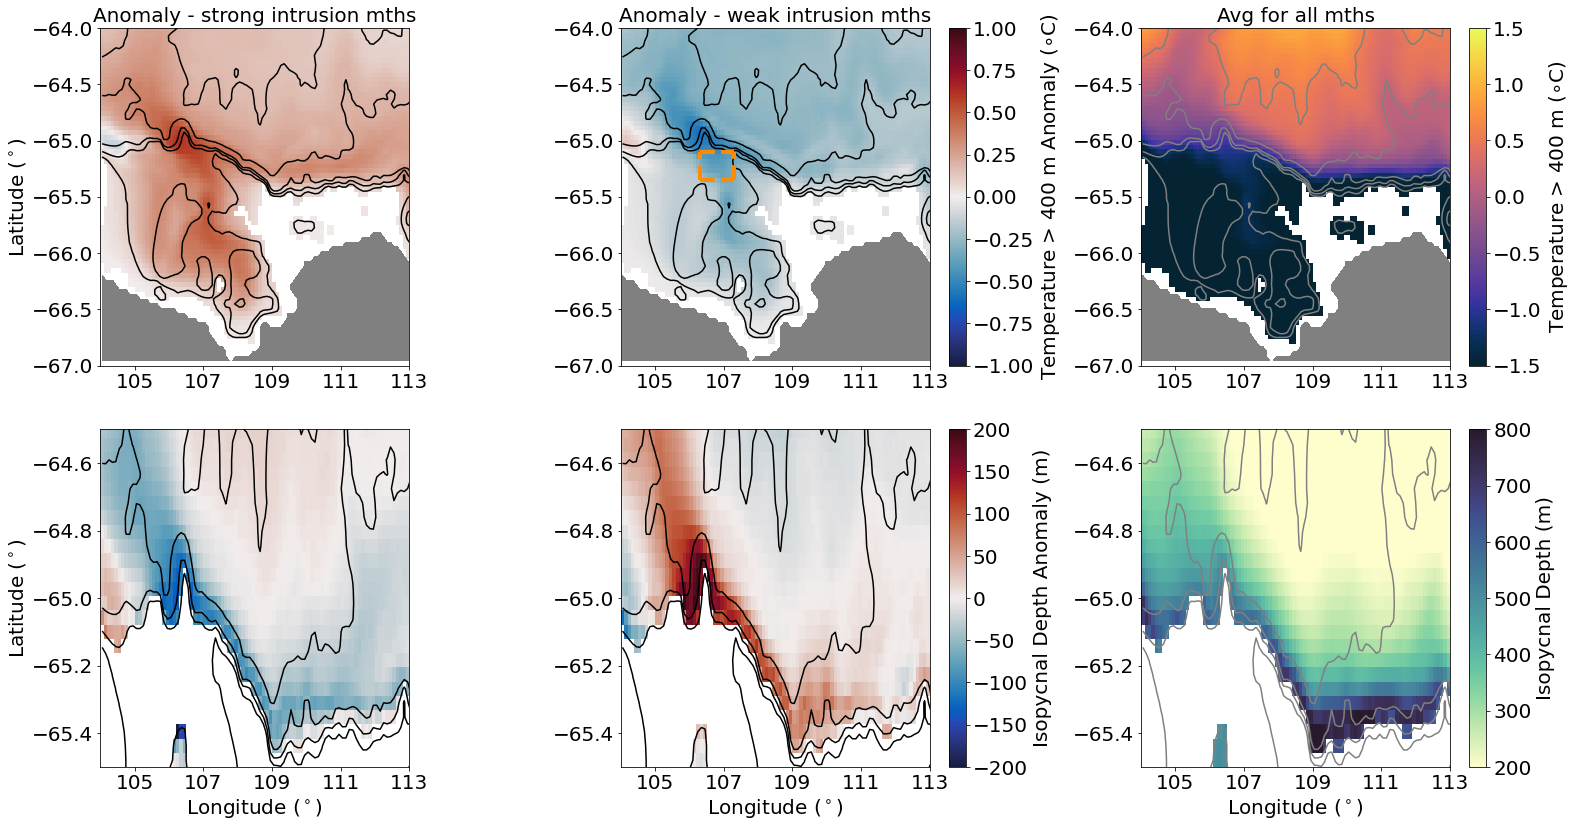

In [47]:
### test new values
fontsize=20

#for nt in range(0,nframes):
fig=plt.figure(figsize=(22, 22))
fig.subplots_adjust(top=0.88)

t_high = temp_high_avg-temp_400m_avg;
t_low = temp_low_avg-temp_400m_avg;
ax0=plt.subplot(431) 
pc = plt.pcolormesh(t_high.xt_ocean,t_high.yt_ocean,
                        t_high, cmap = cmocean.balance, 
                        vmin=-1,vmax=1)
#plt.title('Anomaly for Str Heat Flux (Y) yrs',fontsize=fontsize)
plt.title('Anomaly - strong intrusion mths',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,2000],colors='b',linewidth=5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Temp 400m',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
# colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'($\circ$C)', fontsize = 16,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
#this removes colorbar whilst maintaing figure size
fig.delaxes(fig.axes[1])

ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
#plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(432)      
pc = plt.pcolormesh(t_low.xt_ocean,t_low.yt_ocean,
                       t_low, cmap = cmocean.balance, 
                        vmin=-1,vmax=1)
#plt.title('Anomaly for Weak Heat Flux (Y) yrs',fontsize=fontsize)
plt.title('Anomaly - weak intrusion mths',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.plot([-252.7,-252.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=4)
plt.plot([-251.7,-251.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=4)
plt.plot([-252.7,-251.7],[-65.1, -65.1],color='darkorange',linestyle='--',linewidth=4)
plt.plot([-252.7,-251.7],[-65.35, -65.35],color='darkorange',linestyle='--',linewidth=4)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Temperature > 400 m Anomaly ($\circ$C)', fontsize = fontsize,labelpad=5)
#cbar.set_label(r'($\circ$C)', fontsize = 16,labelpad=5)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#cbar.set_label(r'Temperature > 400 m ($\circ$C)', fontsize = fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)


t_high = iso_high_avg-iso_avg;
t_low = iso_low_avg-iso_avg;
ax0=plt.subplot(434) 
pc = plt.pcolormesh(t_high.xt_ocean,t_high.yt_ocean,
                        t_high, cmap = cmocean.balance, 
                        vmin=-200,vmax=200)
#plt.title('Anomaly for Str Heat Flux (Y) yrs',fontsize=fontsize)
#plt.title('Anomaly for rising Temp yrs',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,2000],colors='b',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Isopycnal Depth (27.82)',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-65.5, -64.5))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'Depth (m)', fontsize = 16,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
#this removes colorbar whilst maintaing figure size
fig.delaxes(fig.axes[4])

ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(435)      
pc = plt.pcolormesh(t_low.xt_ocean,t_low.yt_ocean,
                       t_low, cmap = cmocean.balance, 
                        vmin=-200,vmax=200)
#plt.title('Anomaly for Weak Heat Flux (Y) yrs',fontsize=fontsize)
#plt.title('Anomaly for Lowering T yrs',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
#plt.plot([-252.7,-252.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=4)
#plt.plot([-251.7,-251.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=4)
#plt.plot([-252.7,-251.7],[-65.1, -65.1],color='darkorange',linestyle='--',linewidth=4)
#plt.plot([-252.7,-251.7],[-65.35, -65.35],color='darkorange',linestyle='--',linewidth=4)
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
#plt.title('Anomaly for lowering Temp yrs',fontsize=fontsize)
        #lim
plt.ylim((-65.5, -64.5))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Isopycnal Depth Anomaly (m)', fontsize = fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
#cbar.set_label(r'Isopycnal Depth (m)', fontsize = fontsize,labelpad=5)

ax0=plt.subplot(433)    
pc = plt.pcolormesh(temp_400m_avg.xt_ocean,temp_400m_avg.yt_ocean,
                        temp_400m_avg, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=1.5)
plt.title('Avg for all mths',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='grey',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Temperature > 400 m ($\circ$C)', fontsize = fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(436)    
pc = plt.pcolormesh(iso_avg.xt_ocean,iso_avg.yt_ocean,
                        iso_avg, cmap = cmocean.deep, 
                        vmin=200,vmax=800)
#plt.title('Avg for all yrs',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='grey',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
#plt.title('Avg for all mths',fontsize=fontsize)
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-65.5, -64.5))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.tick_params(labelsize=fontsize)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
cbar.set_label(r'Isopycnal Depth (m)', fontsize = fontsize,labelpad=5)

fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures'
filestr = figdir+'/fig3a_ch4.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

NameError: name 'figdir' is not defined

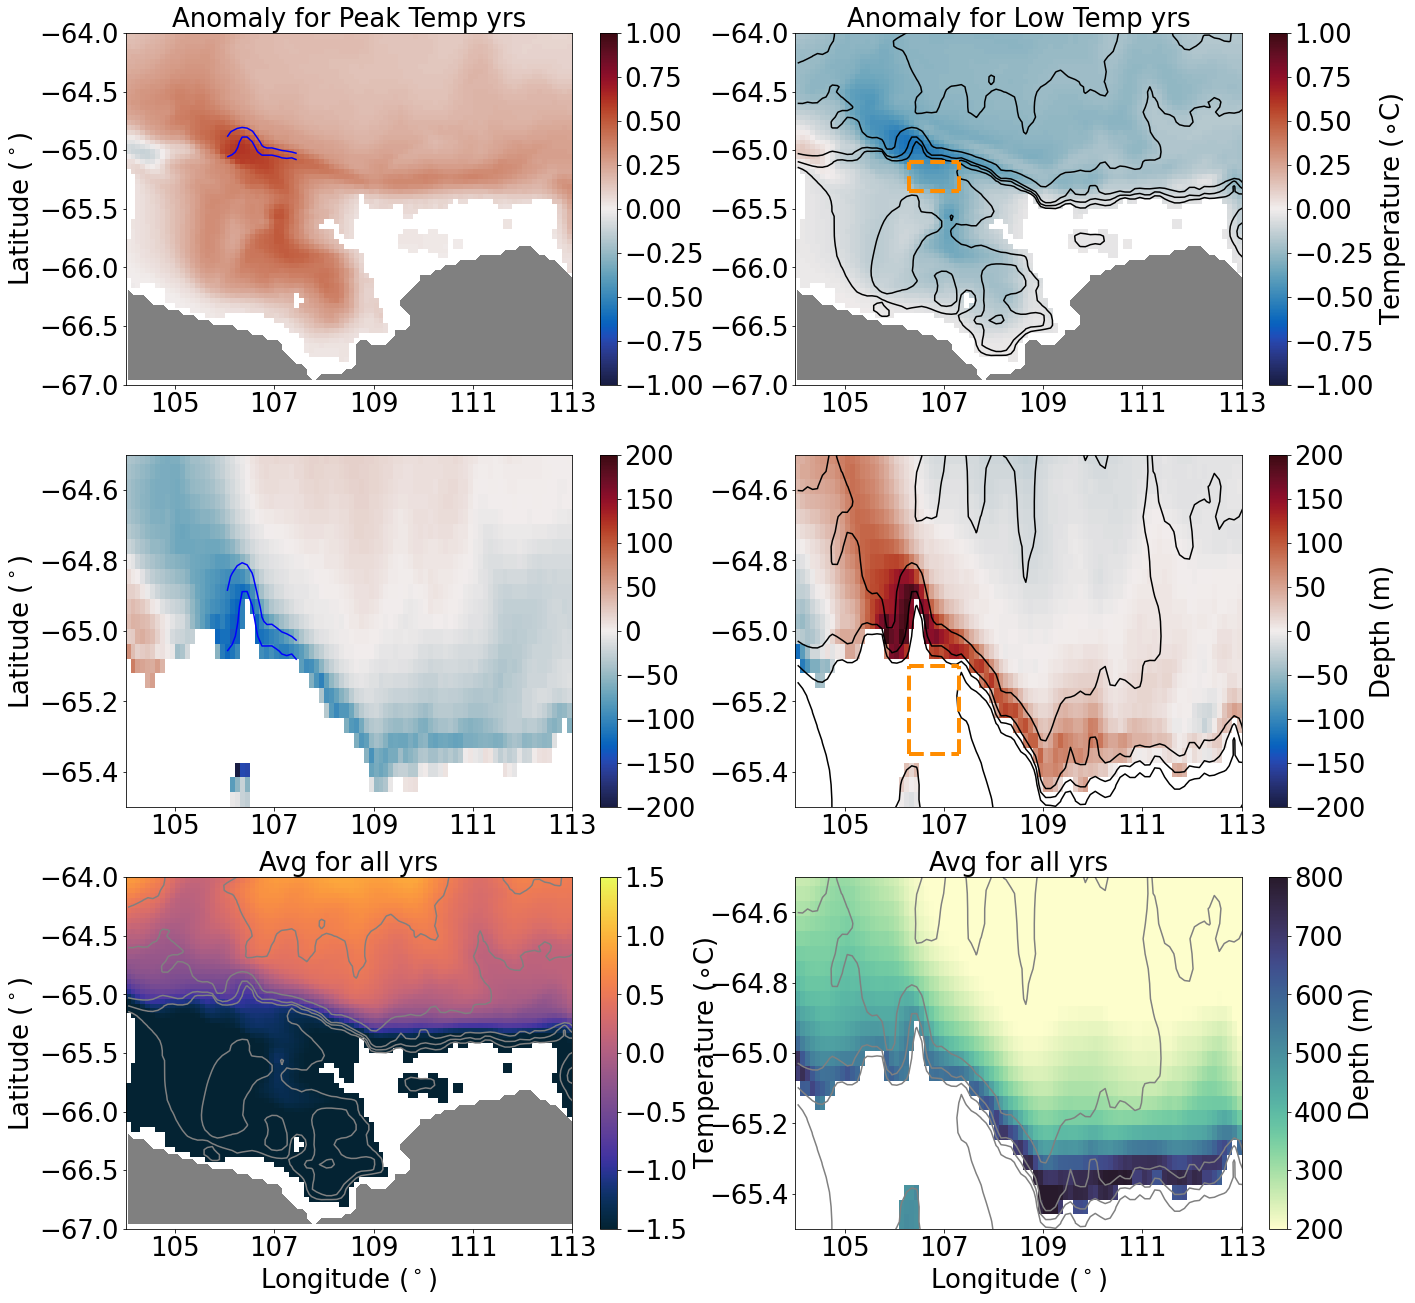

In [50]:
### test new values
fontsize=26

#for nt in range(0,nframes):
fig=plt.figure(figsize=(22, 22))
fig.subplots_adjust(top=0.88)

t_high = temp_high_avg-temp_400m_avg;
t_low = temp_low_avg-temp_400m_avg;
ax0=plt.subplot(321) 
pc = plt.pcolormesh(t_high.xt_ocean,t_high.yt_ocean,
                        t_high, cmap = cmocean.balance, 
                        vmin=-1,vmax=1)
#plt.title('Anomaly for Str Heat Flux (Y) yrs',fontsize=fontsize)
plt.title('Anomaly for Peak Temp yrs',fontsize=fontsize)
        #plot contours
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
plt.contour(ht2.xt_ocean,ht2.yt_ocean,ht2,levels=[1000,2000],colors='b',linewidth=5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Temp 400m',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'($\circ$C)', fontsize = 16,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
#plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(3,2,2)      
pc = plt.pcolormesh(t_low.xt_ocean,t_low.yt_ocean,
                       t_low, cmap = cmocean.balance, 
                        vmin=-1,vmax=1)
#plt.title('Anomaly for Weak Heat Flux (Y) yrs',fontsize=fontsize)
plt.title('Anomaly for Low Temp yrs',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.plot([-252.7,-252.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=4)
plt.plot([-251.7,-251.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=4)
plt.plot([-252.7,-251.7],[-65.1, -65.1],color='darkorange',linestyle='--',linewidth=4)
plt.plot([-252.7,-251.7],[-65.35, -65.35],color='darkorange',linestyle='--',linewidth=4)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'($\circ$C)', fontsize = 16,labelpad=5)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
cbar.set_label(r'Temperature ($\circ$C)', fontsize = fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)


t_high = iso_high_avg-iso_avg;
t_low = iso_low_avg-iso_avg;
ax0=plt.subplot(323) 
pc = plt.pcolormesh(t_high.xt_ocean,t_high.yt_ocean,
                        t_high, cmap = cmocean.balance, 
                        vmin=-200,vmax=200)
#plt.title('Anomaly for Str Heat Flux (Y) yrs',fontsize=fontsize)
#plt.title('Anomaly for rising Temp yrs',fontsize=fontsize)
        #plot contours
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
plt.contour(ht2.xt_ocean,ht2.yt_ocean,ht2,levels=[1000,2000],colors='b',linewidth=5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Isopycnal Depth (27.82)',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-65.5, -64.5))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'Depth (m)', fontsize = 16,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
#plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(3,2,4)      
pc = plt.pcolormesh(t_low.xt_ocean,t_low.yt_ocean,
                       t_low, cmap = cmocean.balance, 
                        vmin=-200,vmax=200)
#plt.title('Anomaly for Weak Heat Flux (Y) yrs',fontsize=fontsize)
#plt.title('Anomaly for Lowering T yrs',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.plot([-252.7,-252.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=4)
plt.plot([-251.7,-251.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=4)
plt.plot([-252.7,-251.7],[-65.1, -65.1],color='darkorange',linestyle='--',linewidth=4)
plt.plot([-252.7,-251.7],[-65.35, -65.35],color='darkorange',linestyle='--',linewidth=4)
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
#plt.title('Anomaly for lowering Temp yrs',fontsize=fontsize)
        #lim
plt.ylim((-65.5, -64.5))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'Depth (m)', fontsize = 16,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
#plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
cbar.set_label(r'Depth (m)', fontsize = fontsize,labelpad=5)

ax0=plt.subplot(3,2,5)    
pc = plt.pcolormesh(temp_400m_avg.xt_ocean,temp_400m_avg.yt_ocean,
                        temp_400m_avg, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=1.5)
plt.title('Avg for all yrs',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='grey',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Temperature ($\circ$C)', fontsize = fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(3,2,6)    
pc = plt.pcolormesh(iso_avg.xt_ocean,iso_avg.yt_ocean,
                        iso_avg, cmap = cmocean.deep, 
                        vmin=200,vmax=800)
#plt.title('Avg for all yrs',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='grey',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.title('Avg for all yrs',fontsize=fontsize)
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-65.5, -64.5))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.tick_params(labelsize=fontsize)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
cbar.set_label(r'Depth (m)', fontsize = fontsize,labelpad=5)


#fig.tight_layout()
#figdir = '/home/581/ns3783/Scripts/Figures/Current'
filestr = figdir+'/fig3a_ch4_right_contours.eps'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

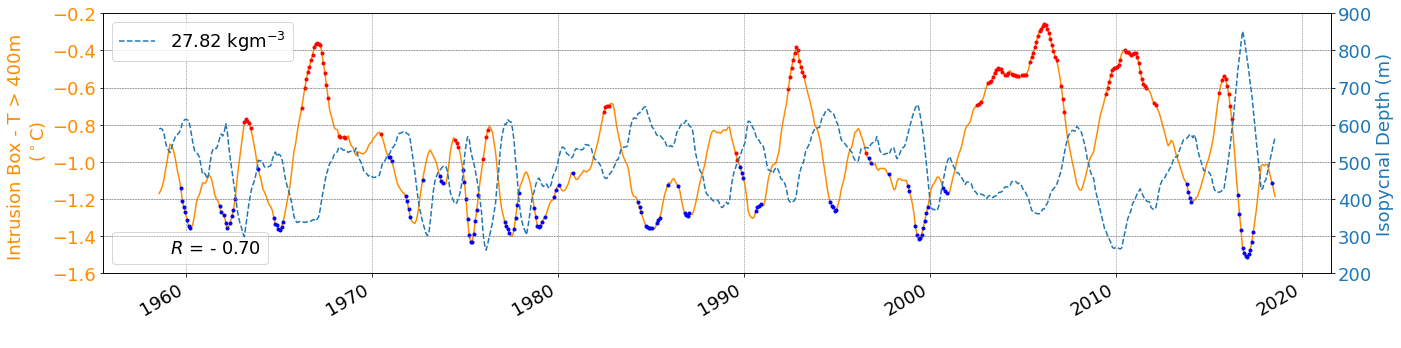

In [42]:
fontsize=18
fig=plt.figure(figsize=(22, 22))
fig.subplots_adjust(top=0.88)

ax1 = plt.subplot(4, 1, 2)
temp_400m_zar.plot(color='darkorange')
#temp_high_mask.plot(color='red')
#temp_low_mask.plot(color='purple')
temp_400m_zar[bt_id].plot(marker='.',color='blue',linestyle='none')
temp_400m_zar[top_id].plot(marker='.',color='red',linestyle='none')

ax1.set_ylabel('Intrusion Box - T > 400m \n ($^\circ$C)', fontsize=fontsize,color='darkorange')
ax1.tick_params(axis='y', labelcolor='darkorange',labelsize=fontsize)
ax1.set_xlabel(' ', fontsize = fontsize)
ax1.tick_params(axis='x',labelsize=fontsize)
#plt.title('Monthly T (Box1) vs Zonal Wind (small grid; -65,-64.5S/-258,-252E) / Rolling mean',fontsize=fontsize)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.ylim([-1.6,-0.2])
#plt.text(100,0.4,"cor = -0.73, lag = 4 months")
#ax1.xaxis.set_minor_locator(MultipleLocator(1))
plt.plot(np.nan,np.nan,color='k',linestyle='none',label='$R$ = - 0.70')
plt.legend(loc="lower left",fontsize=fontsize)

ax2 = ax1.twinx()
#isocon_off_dr.plot(color='C0')
isocon2_off_r.plot(color='C0',linestyle='--')
#isocon_off3_dr.plot(color='C0',linestyle=':')
ax2.set_ylabel('Isopycnal Depth (m)', fontsize=fontsize, color='C0')
ax2.tick_params(axis='x',labelsize=fontsize)
ax2.tick_params(axis='y', labelcolor='C0',labelsize=fontsize)
#ax2.invert_yaxis()
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
#plt.text(700, -0.4, 'cor=0.016', fontsize = 12)
#building legend
#plt.plot(np.nan,np.nan,color='C0',linestyle=':',label='27.80')
plt.plot(np.nan,np.nan,color='C0',linestyle='--',label='27.82 kgm$^{-3}$')
#plt.plot(np.nan,np.nan,color='C0',label='27.83')
plt.legend(loc="upper left",fontsize=fontsize)
plt.ylim([200,900])

figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures'
#figdir = '/home/581/ns3783/Scripts/Figures/New_codes_CFD/Figures'
filestr = figdir+'/Fig3_timeseries.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

In [94]:
pwd

'/home/581/ns3783/Scripts/Figures/New_codes_CFD'

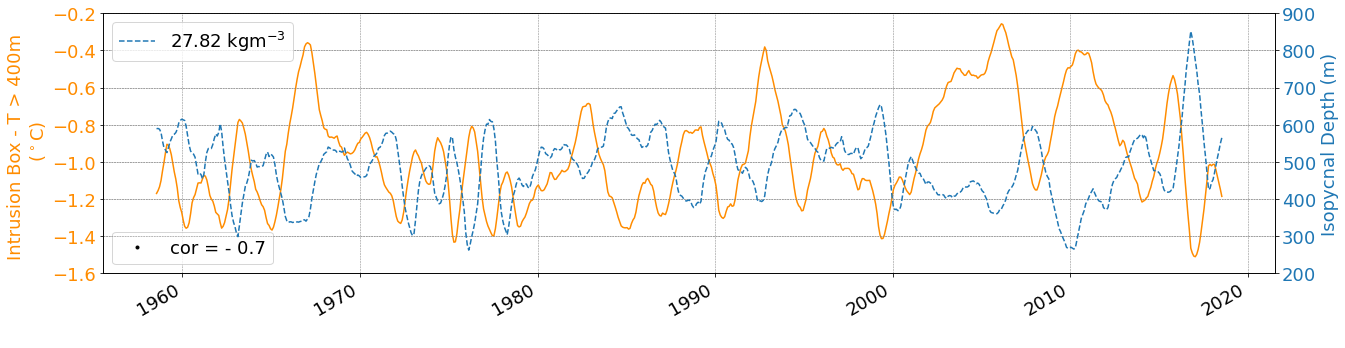

In [43]:
fontsize=18
fig=plt.figure(figsize=(21, 22))
fig.subplots_adjust(top=0.88)

ax1 = plt.subplot(4, 1, 2)
temp_400m_zar.plot(color='darkorange')

ax1.set_ylabel('Intrusion Box - T > 400m \n ($^\circ$C)', fontsize=fontsize,color='darkorange')
ax1.tick_params(axis='y', labelcolor='darkorange',labelsize=fontsize)
ax1.set_xlabel(' ', fontsize = fontsize)
ax1.tick_params(axis='x',labelsize=fontsize)
#plt.title('Monthly T (Box1) vs Zonal Wind (small grid; -65,-64.5S/-258,-252E) / Rolling mean',fontsize=fontsize)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.ylim([-1.6,-0.2])
#plt.text(100,0.4,"cor = -0.73, lag = 4 months")
#ax1.xaxis.set_minor_locator(MultipleLocator(1))
plt.plot(np.nan,np.nan,color='k',marker=".",linestyle='none',label='cor = - 0.7')
plt.legend(loc="lower left",fontsize=fontsize)

ax2 = ax1.twinx()
#isocon_off_dr.plot(color='C0')
isocon2_off_r.plot(color='C0',linestyle='--')
#isocon_off3_dr.plot(color='C0',linestyle=':')
ax2.set_ylabel('Isopycnal Depth (m)', fontsize=fontsize, color='C0')
ax2.tick_params(axis='x',labelsize=fontsize)
ax2.tick_params(axis='y', labelcolor='C0',labelsize=fontsize)
#ax2.invert_yaxis()
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
#plt.text(700, -0.4, 'cor=0.016', fontsize = 12)
#building legend
#plt.plot(np.nan,np.nan,color='C0',linestyle=':',label='27.80')
plt.plot(np.nan,np.nan,color='C0',linestyle='--',label='27.82 kgm$^{-3}$')
#plt.plot(np.nan,np.nan,color='C0',label='27.83')
plt.legend(loc="upper left",fontsize=fontsize)
plt.ylim([200,900])

figdir = '/g/data/jk72/ns3783'
figdir = '/home/581/ns3783/Scripts/Figures/New_codes_CFD/Figures'
filestr = figdir+'/Fig3_timeseries_no_dots.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')